#### Import Modules

In [1]:
import warnings
import pandas as pd
import sys, os


from causalnex.structure import StructureModel

sys.path.append(os.path.abspath(os.path.join('../scripts')))
from eda_pipeline import EDAPipeline
from causal_learning_helper import CausalHelper
warnings.filterwarnings("ignore")

/home/n/anaconda3/envs/env_causal/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
eda_pipeline = EDAPipeline()
preprocessed_trip_df = eda_pipeline.read_data(path="../data/preprocessed_trip.csv", version="v1_preprocessed")
preprocessed_trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534369 entries, 0 to 534368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        534369 non-null  int64  
 1   Trip ID           534369 non-null  int64  
 2   Trip Origin       534369 non-null  object 
 3   Trip Destination  534369 non-null  object 
 4   Trip Start Time   534369 non-null  object 
 5   Trip End Time     534368 non-null  object 
 6   is_weekend        534369 non-null  int64  
 7   is_holiday        534369 non-null  int64  
 8   distance          534369 non-null  float64
 9   speed             534369 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 40.8+ MB


In [3]:
df_driver = eda_pipeline.read_data(path="../data/driver_locations_during_request.csv", version="v1_driver")
df_driver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557740 entries, 0 to 1557739
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   id             1557740 non-null  int64  
 1   order_id       1557740 non-null  int64  
 2   driver_id      1557740 non-null  int64  
 3   driver_action  1557740 non-null  object 
 4   lat            1557740 non-null  float64
 5   lng            1557740 non-null  float64
 6   created_at     0 non-null        float64
 7   updated_at     0 non-null        float64
dtypes: float64(4), int64(3), object(1)
memory usage: 95.1+ MB


#### Merge the two datasets

In [4]:
preprocessed_trip_df['driver_distance'] = preprocessed_trip_df['distance'].apply(lambda x: -1)
preprocessed_trip_df['driver_lat'] = preprocessed_trip_df['distance'].apply(lambda x: 0.0)
preprocessed_trip_df['driver_lng'] = preprocessed_trip_df['distance'].apply(lambda x: 0.0)


In [5]:
causalhelper = CausalHelper()

In [6]:
driver_lat,driver_lng = causalhelper.combine_get_driver_locations(preprocessed_trip_df, df_driver)

In [7]:
preprocessed_trip_df['driver_lat'] = driver_lat
preprocessed_trip_df['driver_lng'] = driver_lng

In [9]:
driver_lat_coordinates = preprocessed_trip_df['driver_lat'].tolist()
driver_lng_coordinates = preprocessed_trip_df['driver_lng'].tolist()
ending_coordinates = []
for i in range(len(driver_lat_coordinates)):
    ending_coordinates.append(f'{driver_lat_coordinates[i]},{driver_lng_coordinates[i]}')

In [10]:
start_coordinates = preprocessed_trip_df['Trip Origin'].tolist()

#### Calculate distance based on coordinates of driver

In [11]:
preprocessed_trip_df['driver_distance'] = eda_pipeline.calculate_distances(start_coordinates, ending_coordinates)


#### Drop all the trips with -1 driver distance which means those orders were not in the 2nd dataset

In [13]:
preprocessed_trip_df_with_drivers = preprocessed_trip_df[preprocessed_trip_df['driver_distance']!=-1]
preprocessed_trip_df_with_drivers.shape

(26436, 13)

#### Compute unfulfilled orders

In [14]:
preprocessed_trip_df_with_drivers['is_fulfilled'] = preprocessed_trip_df_with_drivers['driver_distance'].apply(
    lambda x: 1 if x !=-2 else 0)

In [16]:
preprocessed_trip_df_with_drivers[preprocessed_trip_df_with_drivers['is_fulfilled']==0].shape

(609, 14)

#### Drop Unwanted columns

In [17]:
preprocessed_trip_df_with_drivers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26436 entries, 4 to 53812
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        26436 non-null  int64  
 1   Trip ID           26436 non-null  int64  
 2   Trip Origin       26436 non-null  object 
 3   Trip Destination  26436 non-null  object 
 4   Trip Start Time   26436 non-null  object 
 5   Trip End Time     26436 non-null  object 
 6   is_weekend        26436 non-null  int64  
 7   is_holiday        26436 non-null  int64  
 8   distance          26436 non-null  float64
 9   speed             26436 non-null  float64
 10  driver_distance   26436 non-null  float64
 11  driver_lat        26436 non-null  float64
 12  driver_lng        26436 non-null  float64
 13  is_fulfilled      26436 non-null  int64  
dtypes: float64(5), int64(5), object(4)
memory usage: 3.0+ MB


#### Save Data

In [18]:
preprocessed_trip_df_with_drivers.to_csv("../data/preprocessed_trip_df_with_drivers_fulfilled.csv")

In [19]:
cols = ['Trip ID','Unnamed: 0', 'Trip Origin', 'Trip Destination', 'Trip Start Time', 'Trip End Time', 'driver_lat', 'driver_lng']
preprocessed_trip_df_with_drivers = preprocessed_trip_df_with_drivers.drop(columns=cols)

In [20]:
preprocessed_trip_df_with_drivers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26436 entries, 4 to 53812
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   is_weekend       26436 non-null  int64  
 1   is_holiday       26436 non-null  int64  
 2   distance         26436 non-null  float64
 3   speed            26436 non-null  float64
 4   driver_distance  26436 non-null  float64
 5   is_fulfilled     26436 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 1.4 MB


#### Create Structure Model

In [21]:
sm = StructureModel()

#### Create Edges

#### Transform and encode 

In [27]:
import numpy as np

struct_data = preprocessed_trip_df_with_drivers.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)

print(non_numeric_columns)

[]


In [40]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

# struct_data.head(5)

#### Scale and normalize numerical data

In [28]:
from sklearn import preprocessing

x = struct_data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

#### Apply the NOTEARS algorithm to learn the structure.

In [30]:
from causalnex.structure.notears import from_pandas

sm = from_pandas(df)

#### Visualize

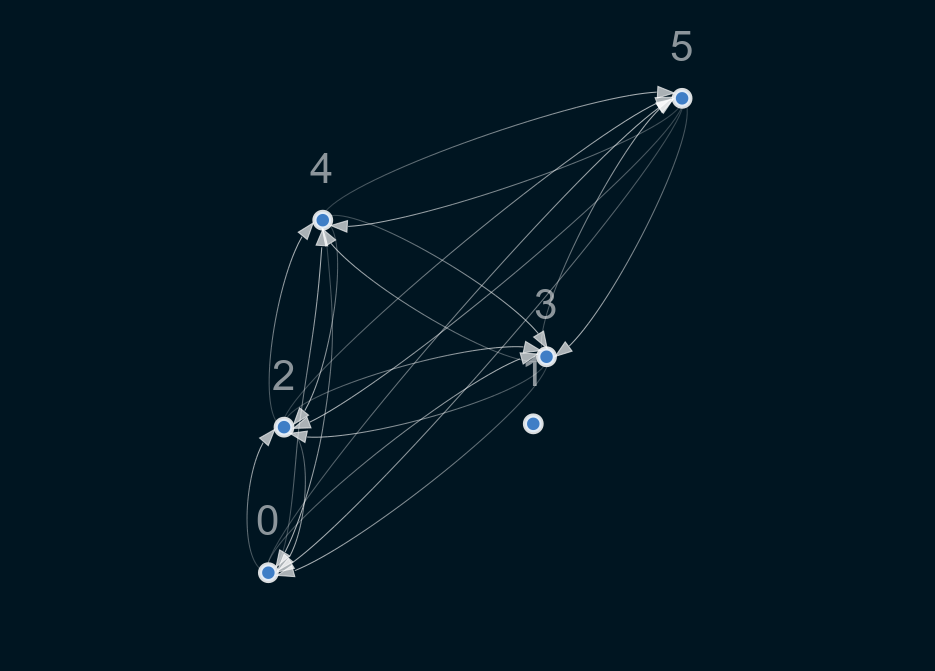

In [31]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE


viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp',
)
Image(viz.draw(format='png'))

`The reason why we have a fully connected graph here is we haven’t applied thresholding to the weaker edges. Thresholding can be applied either by specifying the value for the parameter w_threshold in from_pandas, or we can remove the edges by calling the structure model function, remove_edges_below_threshold.`

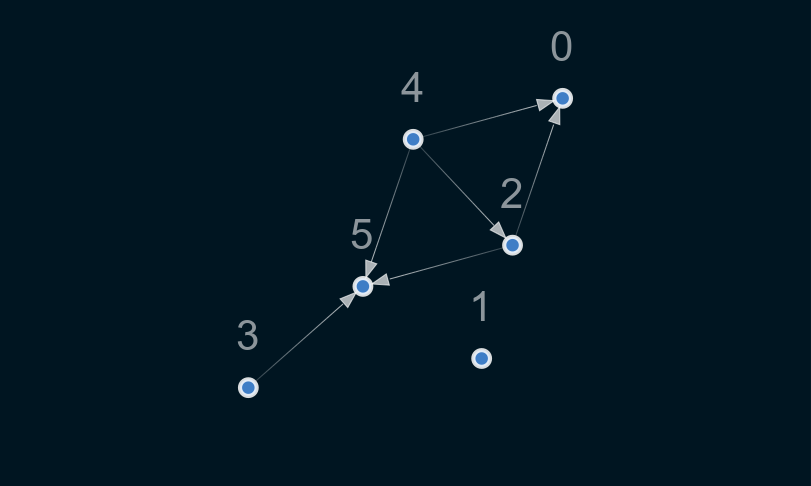

In [32]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

 `Normalized column names`<br>
 0   is_weekend       <br>
 1   is_holiday        <br>  
 2   distance          <br>
 3   speed             <br>
 4   driver_distance   <br>
 5   is_fulfilled  

 {'is_weekend': 0,
 'is_holiday': 1,
 'distance': 2,
 'speed': 3,
 'driver_distance': 4,
 'is_fulfilled': 5}

* Correct relationships <br>
`distance` ---> `is_fulfilled`<br>
`distance` ---> `is_fulfilled` <br>
`driver_distance` ---> `is_fulfilled` <br>

* Incorrect relationships <br>
`distance` ---> `is_weekend` <br>
`driver_distance` ---> `is_weeken` <br>

#### Lets re-run structure learning wuth additional constraints to avoid incorrect relationships

##### Rename cols

In [46]:
df = df.rename(columns={0: "is_weekend", 1: "is_holiday", 2: "distance", 3: "speed",4: "driver_distance", 5: "is_fulfilled"}, errors="raise")

In [47]:
df

,is_weekend,is_holiday,distance,speed,driver_distance,is_fulfilled
0,0.0,0.0,0.030832,0.018849,0.004094,1.0
1,0.0,0.0,0.011927,0.000770,0.006017,1.0
2,0.0,0.0,0.007388,0.000266,0.007518,1.0
3,0.0,0.0,0.008225,0.000519,0.004859,1.0
4,0.0,0.0,0.028036,0.001399,0.003340,1.0
...,...,...,...,...,...,...
26431,0.0,0.0,0.003773,0.000197,0.005521,1.0
26432,1.0,0.0,0.005256,0.001202,0.007197,1.0
26433,1.0,0.0,0.039313,0.001822,0.007742,1.0
26434,0.0,0.0,0.026934,0.000890,0.005839,1.0


In [48]:
sm = from_pandas(df, tabu_edges=[("driver_distance", "is_weekend"),("distance", "is_weekend")], w_threshold=0.8)

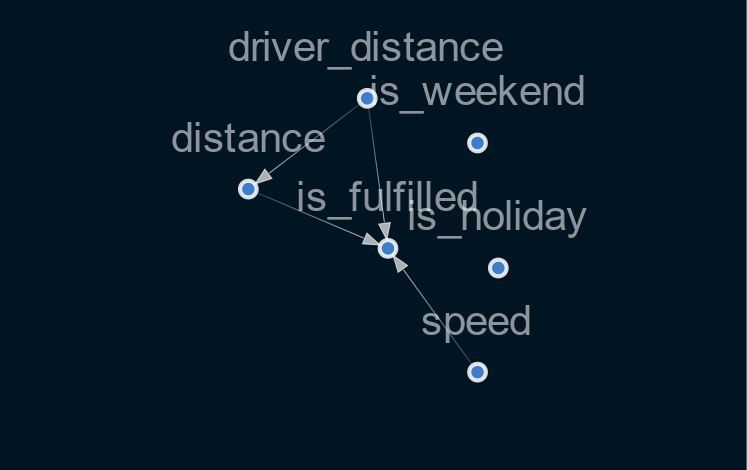

In [49]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [50]:
sm.add_edge("is_weekend", "is_fulfilled")
sm.add_edge("is_holiday", "is_fulfilled")

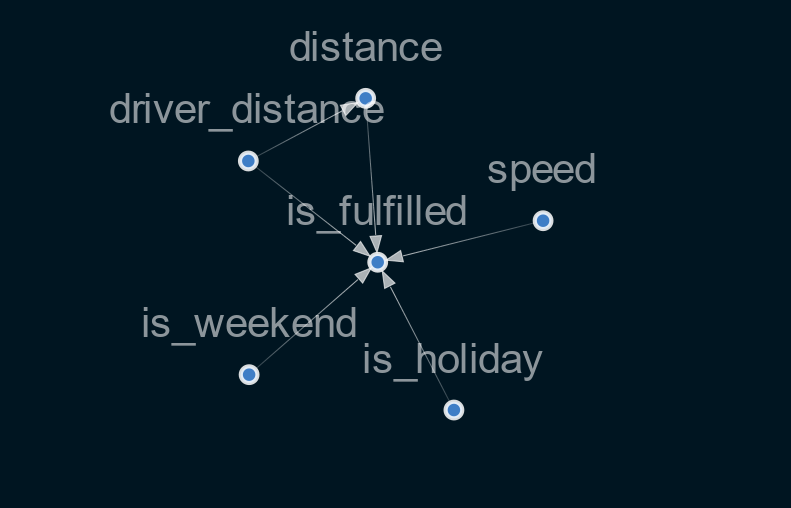

In [51]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

#### Exporting the Structure

In [53]:
import networkx as nx

nx.drawing.nx_pydot.write_dot(sm, '../graphs/graph.dot')

#### Fitting the Conditional Distribution of the Bayesian Network

In [54]:
from causalnex.network import BayesianNetwork

bn = BayesianNetwork(sm)

#### Preparing the Discretised Data

#### Cardinality of Categorical Features

In [85]:
df_c = preprocessed_trip_df_with_drivers.copy()
df_c

,is_weekend,is_holiday,distance,speed,driver_distance,is_fulfilled
4,0,0,20.984319,348.126952,0.694264,1
5,0,0,8.127195,14.237422,1.959786,1
6,0,0,5.040921,4.929996,2.947683,1
7,0,0,5.609962,9.607927,1.197389,1
8,0,0,19.082399,25.854963,0.197853,1
...,...,...,...,...,...,...
44825,0,0,2.582307,3.661404,1.633417,1
44847,1,0,3.590521,22.209406,2.736381,1
46712,1,0,26.751642,33.661626,3.094992,1
51071,0,0,18.333328,16.450643,1.842496,1


In [86]:
df_c['is_weekend'] = df_c['is_weekend'].apply(lambda x: 'weekday' if x == 0 else "weekend")
df_c['is_holiday'] = df_c['is_holiday'].apply(lambda x: 'holiday' if x !=0 else "no-holiday")
df_c['is_fulfilled'] = df_c['is_fulfilled'].apply(lambda x: 'fulfilled' if x !=0 else "unfulfilled")

In [87]:
df_c

,is_weekend,is_holiday,distance,speed,driver_distance,is_fulfilled
4,weekday,no-holiday,20.984319,348.126952,0.694264,fulfilled
5,weekday,no-holiday,8.127195,14.237422,1.959786,fulfilled
6,weekday,no-holiday,5.040921,4.929996,2.947683,fulfilled
7,weekday,no-holiday,5.609962,9.607927,1.197389,fulfilled
8,weekday,no-holiday,19.082399,25.854963,0.197853,fulfilled
...,...,...,...,...,...,...
44825,weekday,no-holiday,2.582307,3.661404,1.633417,fulfilled
44847,weekend,no-holiday,3.590521,22.209406,2.736381,fulfilled
46712,weekend,no-holiday,26.751642,33.661626,3.094992,fulfilled
51071,weekday,no-holiday,18.333328,16.450643,1.842496,fulfilled


#### Discretising Numeric Features 
To make numeric features categorical, they must first be discretised.

In [88]:
from causalnex.discretiser import Discretiser

In [99]:
discretised_data = df_c.copy()

In [100]:
discretised_data["distance"] = Discretiser(method="fixed",
        numeric_split_points=[1,100]).transform(discretised_data["distance"].values)
discretised_data["distance"].value_counts()

1    26039
0      390
2        7
Name: distance, dtype: int64

In [101]:
discretised_data["driver_distance"] = Discretiser(method="fixed",
        numeric_split_points=[1,100]).transform(discretised_data["driver_distance"].values)
discretised_data["driver_distance"].value_counts()

1    17361
0     9073
2        2
Name: driver_distance, dtype: int64

In [102]:
discretised_data["speed"] = Discretiser(method="fixed",
        numeric_split_points=[1,100]).transform(discretised_data["speed"].values)
discretised_data["speed"].value_counts()

1    24515
2     1681
0      240
Name: speed, dtype: int64

#### Create Labels for Numeric Features
To make the discretised categories more readable, we can map the category labels onto something more meaningful in the same way that we mapped category feature values.

In [105]:
distance_map = {
    0: "short-distance",
    1: "medium-distance",
    2: "long-distance"
}
speed_map = {
    0: "slow-speed",
    1: "medium-speed",
    2: "fast-speed"
}

In [106]:
discretised_data["distance"] = discretised_data["distance"].map(distance_map)
discretised_data["driver_distance"] = discretised_data["driver_distance"].map(distance_map)
discretised_data["speed"] = discretised_data["speed"].map(speed_map)

In [107]:
discretised_data

,is_weekend,is_holiday,distance,speed,driver_distance,is_fulfilled
4,weekday,no-holiday,medium-distance,fast-speed,short-distance,fulfilled
5,weekday,no-holiday,medium-distance,medium-speed,medium-distance,fulfilled
6,weekday,no-holiday,medium-distance,medium-speed,medium-distance,fulfilled
7,weekday,no-holiday,medium-distance,medium-speed,medium-distance,fulfilled
8,weekday,no-holiday,medium-distance,medium-speed,short-distance,fulfilled
...,...,...,...,...,...,...
44825,weekday,no-holiday,medium-distance,medium-speed,medium-distance,fulfilled
44847,weekend,no-holiday,medium-distance,medium-speed,medium-distance,fulfilled
46712,weekend,no-holiday,medium-distance,medium-speed,medium-distance,fulfilled
51071,weekday,no-holiday,medium-distance,medium-speed,medium-distance,fulfilled


#### Train / Test Split
Like many other machine learning models, we will use a train and test split to help us validate our findings.

In [108]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=7)

#### Model Probability
With the learnt structure model from earlier and the discretised data, we can now fit the probability distrbution of the Bayesian Network. The first step in this is specifying all of the states that each node can take. This can be done either from data, or providing a dictionary of node values. We use the full dataset here to avoid cases where states in our test set do not exist in the training set. For real-world applications, these states may need to be provided using the dictionary method.

In [109]:
bn = bn.fit_node_states(discretised_data)

#### Fit Conditional Probability Distributions
The fit_cpds method of BayesianNetwork accepts a dataset to learn the conditional probablilty distributions (CPDs) of each node, along with a method of how to do this fit.

In [110]:
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [112]:
bn.cpds["is_fulfilled"]

distance        long-distance                                                  \
driver_distance long-distance                                                   
is_holiday         no-holiday                                                   
is_weekend            weekday                            weekend                
speed              fast-speed medium-speed slow-speed fast-speed medium-speed   
is_fulfilled                                                                    
fulfilled                0.75          0.5        0.5        0.5          0.5   
unfulfilled              0.25          0.5        0.5        0.5          0.5   

distance                                                                       \
driver_distance            medium-distance                                      
is_holiday                      no-holiday                                      
is_weekend                         weekday                            weekend   
speed           slow-speed      fast-speed medium-speed slow-speed fast-speed   
is_fulfilled                                                                    
fulfilled              0.5        0.833333          0.5        0.5        0.5   
unfulfilled            0.5        0.166667          0.5        0.5        0.5   

distance         ...  short-distance                                     \
driver_distance  ... medium-distance                                      
is_holiday       ...      no-holiday                                      
is_weekend       ...         weekday    weekend                           
speed            ...      slow-speed fast-speed medium-speed slow-speed   
is_fulfilled     ...                                                      
fulfilled        ...            0.96        0.5     0.952381   0.857143   
unfulfilled      ...            0.04        0.5     0.047619   0.142857   

distance                                                           \
driver_distance short-distance                                      
is_holiday          no-holiday                                      
is_weekend             weekday                            weekend   
speed               fast-speed medium-speed slow-speed fast-speed   
is_fulfilled                                                        
fulfilled             0.666667     0.930435       0.75        0.5   
unfulfilled           0.333333     0.069565       0.25        0.5   

distance                                 
driver_distance                          
is_holiday                               
is_weekend                               
speed           medium-speed slow-speed  
is_fulfilled                             
fulfilled           0.857143   0.833333  
unfulfilled         0.142857   0.166667  

[2 rows x 54 columns]

#### Predict the State given the Input Data
The predict method of BayesianNetwork allows us to make predictions based on the data using the learnt Bayesian Network. For example, we want to predict if a trip is fulfilled or not based on the input data. Imagine we have a trip data that looks like this:

In [113]:
discretised_data.loc[57, discretised_data.columns != 'is_fulfilled']

is_weekend                 weekday
is_holiday              no-holiday
distance           medium-distance
speed                 medium-speed
driver_distance    medium-distance
Name: 57, dtype: object

In [114]:
predictions = bn.predict(discretised_data, "is_fulfilled")

In [115]:
print(f"The prediction is '{predictions.loc[57, 'is_fulfilled_prediction']}'")

The prediction is 'fulfilled'


The prediction by the Bayesian Network turns out to be a 'fulfilled'. Let’s compare this to the ground truth:

In [116]:
print(f"The ground truth is '{discretised_data.loc[57, 'is_fulfilled']}'")

The ground truth is 'fulfilled'


### Model Quality

#### Classification Report
To obtain a classification report using a BN, we need to provide a test set, and the node we are trying to classify. The report will predict the target node for all rows in the test set, and evaluate how well those predictions are made.



In [117]:
from causalnex.evaluation import classification_report

classification_report(bn, test, "is_fulfilled")

{'is_fulfilled_fulfilled': {'precision': 0.9735249621785174,
  'recall': 1.0,
  'f1-score': 0.9865848984285166,
  'support': 2574},
 'is_fulfilled_unfulfilled': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 70},
 'accuracy': 0.9735249621785174,
 'macro avg': {'precision': 0.4867624810892587,
  'recall': 0.5,
  'f1-score': 0.4932924492142583,
  'support': 2644},
 'weighted avg': {'precision': 0.9477508519846837,
  'recall': 0.9735249621785174,
  'f1-score': 0.9604650259285181,
  'support': 2644}}

For the predictions where the a trip is `fulfilled`, the `precision`, `recall`, `f1-score`, and `support` are really good, 
but For the predictions where the a trip is `unfulfilled`, the model we have defined has 0 in `precision`, `recall`, and `f1-score`, may be this because of the fact that the number of unfulfilled orders are really small comapred to the fulfilled ones.

#### ROC / AUC
Receiver Operating Characteristics (ROC), and the Area Under the ROC Curve (AUC) can be obtained using the roc_auc method within the CausalNex metrics module. Again, a test set and target node must be provided. The ROC curve is computed by micro-averaging predictions made across all states (classes) of the target node.

In [120]:
from causalnex.evaluation import roc_auc
roc, auc = roc_auc(bn, test, "is_fulfilled")
print(auc)
#The AUC value for our model is high, giving us confidence in the performance.

0.9923063894845979


### Querying Marginals
After iterating over our model structure, CPDs, and validating our model quality, we can query our model under different observations to gain insights.

#### Baseline Marginals
To query the model for baseline marginals that reflect the population as a whole, a query method can be used. First let’s update our model using the complete dataset, since the one we currently have was only built from training data.

In [121]:
bn = bn.fit_cpds(discretised_data, method="BayesianEstimator", bayes_prior="K2")

For inference, we must create a new InferenceEngine from our BayesianNetwork, which lets us query the model. The query method will compute the marginal likelihood of all states for all nodes.

In [122]:
from causalnex.inference import InferenceEngine

ie = InferenceEngine(bn)
marginals = ie.query()
marginals["is_fulfilled"]

{'fulfilled': 0.9756713018850699, 'unfulfilled': 0.02432869811492986}

The output observed tells us that `P(is_fulfilled=fulfilled) = 0.97`, and the `P(is_fulfilled=unfulfilled) = 0.02`. As a quick sanity check, we can compute what proportion of our dataset are `unfulfilled`, which should be approximately the same.

In [123]:
import numpy as np

labels, counts = np.unique(discretised_data["is_fulfilled"], return_counts=True)
list(zip(labels, counts))

[('fulfilled', 25827), ('unfulfilled', 609)]

In [124]:
unfulfilled_proportion = 609/(25827+609)
unfulfilled_proportion

0.02303676804357694

The proportion of the `unfulfilled trips is 0.023`- which is close to our computed marginal likelihood.

### Marginals after Observations
We can also query the marginal likelihood of states in our network given some observations. These observations can be made anywhere in the network, and their impact will be propagated through to the node of interest.

#### Likelihood of `is_fulfilled` based on `distance`

In [125]:
distance_map

{0: 'short-distance', 1: 'medium-distance', 2: 'long-distance'}

In [126]:
marginals_short = ie.query({"distance": "short-distance"})
marginals_medium = ie.query({"distance": "medium-distance"})
marginals_long = ie.query({"distance": "long-distance"})
print("Marginal is_fulfilled | Short Distance", marginals_short["is_fulfilled"])
print("Marginal is_fulfilled | Medium Distance", marginals_medium["is_fulfilled"])
print("Marginal is_fulfilled | Long Distance", marginals_long["is_fulfilled"])

Marginal is_fulfilled | Short Distance {'fulfilled': 0.9351709806996253, 'unfulfilled': 0.06482901930037457}
Marginal is_fulfilled | Medium Distance {'fulfilled': 0.9764371976901707, 'unfulfilled': 0.023562802309829333}
Marginal is_fulfilled | Long Distance {'fulfilled': 0.5160477162995615, 'unfulfilled': 0.48395228370043847}


#### Likelihood of `is_fulfilled` based on `driver_distance`

In [129]:
marginals_short = ie.query({"driver_distance": "short-distance"})
marginals_medium = ie.query({"driver_distance": "medium-distance"})
marginals_long = ie.query({"driver_distance": "long-distance"})
print("Marginal is_fulfilled | Short Driver Distance", marginals_short["is_fulfilled"])
print("Marginal is_fulfilled | Medium Driver Distance", marginals_medium["is_fulfilled"])
print("Marginal is_fulfilled | Long Driver Distance", marginals_long["is_fulfilled"])

Marginal is_fulfilled | Short Driver Distance {'fulfilled': 0.9313264248404043, 'unfulfilled': 0.06867357515959566}
Marginal is_fulfilled | Medium Driver Distance {'fulfilled': 0.998928295271488, 'unfulfilled': 0.0010717047285120375}
Marginal is_fulfilled | Long Driver Distance {'fulfilled': 0.508169677988868, 'unfulfilled': 0.491830322011132}


#### Likelihood of `is_fulfilled` based on `speed`

In [128]:
speed_map

{0: 'slow-speed', 1: 'medium-speed', 2: 'fast-speed'}

In [130]:
marginals_short = ie.query({"speed": "slow-speed"})
marginals_medium = ie.query({"speed": "medium-speed"})
marginals_long = ie.query({"speed": "fast-speed"})
print("Marginal is_fulfilled | Slow Speed", marginals_short["is_fulfilled"])
print("Marginal is_fulfilled | Medium Speed", marginals_medium["is_fulfilled"])
print("Marginal is_fulfilled | fast-speed", marginals_long["is_fulfilled"])

Marginal is_fulfilled | Slow Speed {'fulfilled': 0.931565132435903, 'unfulfilled': 0.06843486756409696}
Marginal is_fulfilled | Medium Speed {'fulfilled': 0.9757920185405659, 'unfulfilled': 0.02420798145943412}
Marginal is_fulfilled | fast-speed {'fulfilled': 0.9802314073019048, 'unfulfilled': 0.01976859269809524}


## Do Calculus

In [59]:
df_c[df_c['is_fulfilled']=='unfulfilled']

,is_weekend,is_holiday,distance,speed,driver_distance,is_fulfilled
620,0.0,0.0,0.011176,0.000314,0.0,unfulfilled
648,0.0,0.0,0.008491,0.000725,0.0,unfulfilled
717,0.0,0.0,0.034200,0.001199,0.0,unfulfilled
976,0.0,0.0,0.003633,0.000202,0.0,unfulfilled
1014,0.0,0.0,0.002328,0.000103,0.0,unfulfilled
...,...,...,...,...,...,...
26217,0.0,0.0,0.004860,0.000350,0.0,unfulfilled
26241,0.0,0.0,0.003338,0.000170,0.0,unfulfilled
26255,0.0,0.0,0.006002,0.007681,0.0,unfulfilled
26330,0.0,0.0,0.009839,0.000275,0.0,unfulfilled


In [37]:
preprocessed_trip_df[preprocessed_trip_df['driver_lng']!=0.0]

,Unnamed: 0,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,is_weekend,is_holiday,distance,speed,driver_distance,driver_lat,driver_lng
